5. Find a geometrically optimized wind farm layout for the areas N-9.1, N-9.2 and N-9.3 using FOXES (you can use the 
provided material for reference but we want to see the code).  
6. Calculate the yield of the areas N-9.1, N-9.2, N-9.3 without external effects. Use the long-term corrected ERA5 data as 
input.  
7. Use three other FOXES setups of your choice (wake models) to calculate the yield again and plot the differences. Explain 
your results. 
8. Pick one of your four FOXES setups. Next, run a FOXES simulation for all existing and future wind farms. Calculate the 
energy yield of your wind farm under the influence of both internal and external wakes. 
9. Derive  the  wake  losses.  This  is,  in  percentage,  the  yield  you  lose  due  to  the  wake  effect, relative  to  the  theoretical 
situation in which no wakes would occur. Estimate what part can be allocated to external wake effects (other wind 
farms), and what part can be allocated to internal wake effects (the wind farm itself).

In [1]:
import os
import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import foxes
import foxes.variables as FV
import foxes.constants as FC
import foxes.opt.problems.layout.geom_layouts as grg# Purely geometrical layout problems (wake effects are not evaluated).
from foxes.opt.problems.layout import FarmLayoutOptProblem
from foxes.opt.constraints import FarmBoundaryConstraint, MinDistConstraint
from foxes.opt.objectives import MaxFarmPower

from iwopy.interfaces.pymoo import Optimizer_pymoo        # some optimization Package idk
import geopandas as gpd



# Function to read and extract data from netcdf files
def read_netcdf(path):
    data = nc.Dataset(path, 'r')
    return data

# Function to read and extract data from csv files
def read_csv(path):
    data = pd.read_csv(path)
    return data

foxes.core.wake_model.WakeModel

### Layout Generation with wake

In [ ]:
## get timeseries-data (here ERA5 as example)-------
from ERA5 import load_data,calculate_wind_speed,calculate_wind_direction,calculate_averages,check_data_gaps

Era5_path = 'data/reanalysis'  
start_year = 2000
end_year = 2023
    
Era5_data = load_data(Era5_path, start_year, end_year)
Era5_data = calculate_wind_speed(Era5_data)
Era5_data = calculate_wind_direction(Era5_data)
##--------------------------------------------------
data = Era5_data
 
print(type(data["Time [UTC]"]))  
data.columns

c:\Advanced Programming\Project\StudentProject-Yield-Predictions-Offshore\ERA5.py:62: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_range = pd.date_range(start=Era5_data.index.min(), end=Era5_data.index.max(), freq='H')


Data Availability is 99.97%
Missing time periods are:
DatetimeIndex(['2023-02-26 00:00:00', '2023-02-26 01:00:00',
               '2023-02-26 02:00:00', '2023-02-26 03:00:00',
               '2023-02-26 04:00:00', '2023-02-26 05:00:00',
               '2023-02-26 06:00:00', '2023-02-26 07:00:00',
               '2023-02-26 08:00:00', '2023-02-26 09:00:00',
               '2023-02-26 10:00:00', '2023-02-26 11:00:00',
               '2023-02-26 12:00:00', '2023-02-26 13:00:00',
               '2023-02-26 14:00:00', '2023-02-26 15:00:00',
               '2023-02-26 16:00:00', '2023-02-26 17:00:00',
               '2023-02-26 18:00:00', '2023-02-26 19:00:00',
               '2023-02-26 20:00:00', '2023-02-26 21:00:00',
               '2023-02-26 22:00:00', '2023-02-26 23:00:00',
               '2023-02-27 00:00:00', '2023-02-27 01:00:00',
               '2023-02-27 02:00:00', '2023-02-27 03:00:00',
               '2023-02-27 04:00:00', '2023-02-27 05:00:00',
               '2023-02-27 06:0

Index(['Time [UTC]', 'u100', 'v100', 'u10', 'v10', 'WS100', 'WS10', 'WD100',
       'WD10'],
      dtype='object')

In [ ]:
# 1. Create geo. boundary
site_shp = gpd.read_file('data/shapefiles/FEP2024_PreDraft/site.shp')
df_n91 = site_shp[site_shp['name_fep']=='N-9.1']

print(np.array(df_n91.get_coordinates()))
boundary = foxes.utils.geom2d.ClosedPolygon(
    np.array(df_n91.get_coordinates())
    ) # put the coords of N9.1 into foxes-boundary as an np.array


[[4037217.674381  3480275.087553 ]
 [4034831.0394465 3482291.700966 ]
 [4050887.351522  3500481.6654685]
 [4057170.143415  3492259.3994785]
 [4037217.674381  3480275.087553 ]]


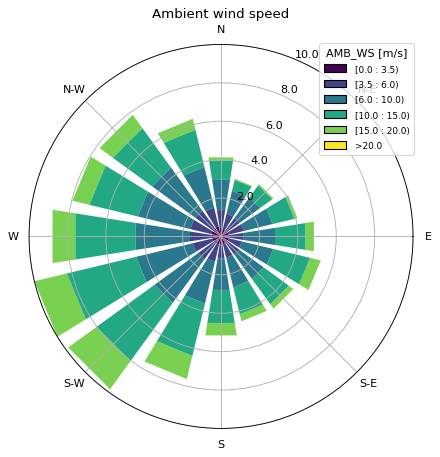

In [ ]:
# 2. create the states object and have a look at the wind rose, look at input States 
#    Wind and other atmospheric inflow conditions are called `States`
states = foxes.input.states.Timeseries(                           # StatesTable for panda df or pd readable file (single height)
    data_source = data ,                                           # the data
    output_vars = [FV.WS, FV.WD, FV.TI, FV.RHO],
    var2col =     {FV.WS: "WS100", FV.WD: "WD100", FV.TI: "ti"}, # Mapping from variable names to data column names

    fixed_vars =  {FV.RHO: 1.225, FV.TI: 0.05},                  # ?? what is TI ??
)

# Plot windrose
o = foxes.output.StatesRosePlotOutput(states, point=[0., 0., 100.])
fig = o.get_figure(16, FV.AMB_WS, [0, 3.5, 6, 10, 15, 20], figsize=(6, 6))
plt.show()

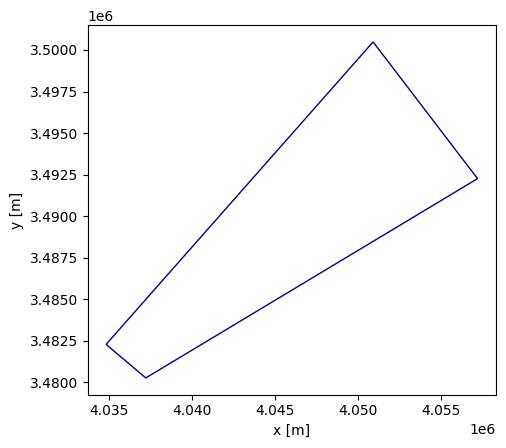

In [ ]:
# This is what the wind farm area looks like:
fig, ax = plt.subplots()
boundary.add_to_figure(ax)
plt.show()

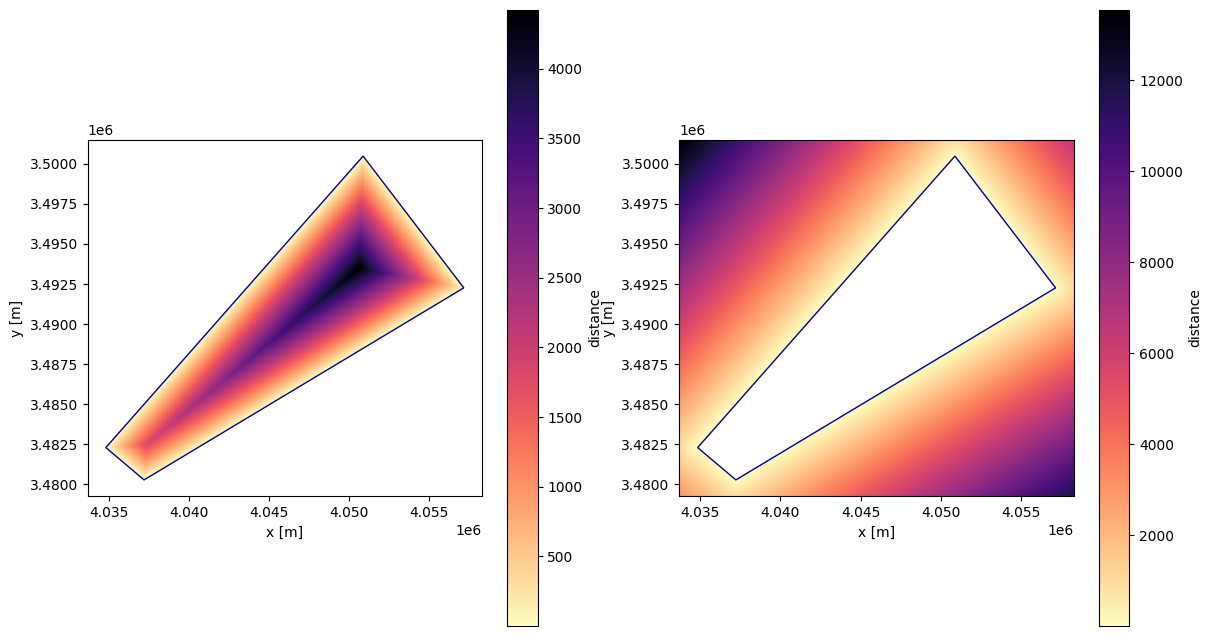

In [ ]:
#### From the example , not sure if needed
#Later on we wish to apply boundary constraints that make sure all turbines are placed within this area geometry. 
#These conditions make use of the minimal distance calculation from each point in question to the boundary. 
#We can check the results by plotting again, now using the fill_mode option:
fig, axs = plt.subplots(1, 2, figsize=(14, 8))
boundary.add_to_figure(axs[0], fill_mode="dist_inside")
boundary.add_to_figure(axs[1], fill_mode="dist_outside")
plt.show()

Turbine 0, T0: NREL5MW
Turbine 1, T1: NREL5MW
Turbine 2, T2: NREL5MW
Turbine 3, T3: NREL5MW
Turbine 4, T4: NREL5MW
Turbine 5, T5: NREL5MW
Turbine 6, T6: NREL5MW
Turbine 7, T7: NREL5MW
Turbine 8, T8: NREL5MW
Turbine 9, T9: NREL5MW


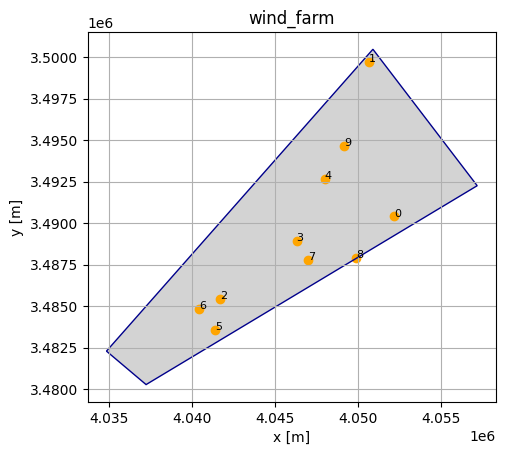

In [ ]:
# setup the model book and a wind farm with n turbines in some initial layout, including the boundary:
farm = foxes.WindFarm(boundary=boundary)

foxes.input.farm_layout.add_from_df(
    farm, 
    read_csv("NoWake_Layout.csv"),
    turbine_models=["NREL5MW"]
)

ax = foxes.output.FarmLayoutOutput(farm).get_figure()

plt.show()

In [ ]:
# define the algorithm and the layout optimization problem. 
algo = foxes.algorithms.Downwind(
    farm,
    states,
    rotor_model="centre",
    wake_models=["Bastankhah025_linear_k002"],
    partial_wakes=None,
    verbosity=0,
)

problem = FarmLayoutOptProblem("layout_opt", algo)
problem.add_objective(MaxFarmPower(problem))
problem.add_constraint(FarmBoundaryConstraint(problem))
problem.add_constraint(MinDistConstraint(problem, min_dist=2., min_dist_unit="D"))
problem.add_constraint(grg.Valid(problem))

problem.initialize()

Problem 'layout_opt' (FarmLayoutOptProblem): Initializing
---------------------------------------------------------
  n_vars_int  : 0
  n_vars_float: 20
---------------------------------------------------------
  n_objectives: 1
  n_obj_cmptns: 1
---------------------------------------------------------
  n_constraints: 3
  n_con_cmptns: 56
---------------------------------------------------------


Next, we have to select an optimizer. Here we pick the Genetic algorithm from `pymoo`, called [GA](https://pymoo.org/algorithms/soo/ga.html):

In [ ]:
solver = Optimizer_pymoo(
    problem,
    problem_pars=dict(vectorize=True),
    algo_pars=dict(
        type="GA",
        pop_size=50,      # the number of layouts per generation,  more Turbines require mor Layouts or we won't get a success
        seed=42,          # the random seed, for reproducible results
    ),
    setup_pars=dict(),
    term_pars=dict(
       # type="default",
        n_max_gen=100,     # the number of generations 
       # ftol=1e-6,
       # xtol=1e-3,
    ),
)
solver.initialize()
solver.print_info()

Loading pymoo
pymoo successfully loaded
Initializing Optimizer_pymoo
Selecting sampling: float_random (FloatRandomSampling)
Selecting algorithm: GA (GA)

Problem:
--------
  vectorize: True

Algorithm:
----------
  type: GA
  pop_size: 50
  seed: 42

Termination:
------------
  n_max_gen: 100



In [ ]:
# Now let's run the optimization:
results = solver.solve()
solver.finalize(results)

In [ ]:

print()
print(results)
print(results.problem_results)

: 

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

foxes.output.FarmLayoutOutput(farm).get_figure(fig=fig, ax=axs[0])

o = foxes.output.FlowPlots2D(algo, results.problem_results)
p_min = np.array([-100.0, -350.0])
p_max = np.array([1100.0, 1600.0])
fig = o.get_mean_fig_xy("WS", resolution=20, fig=fig, ax=axs[1],
    xmin=p_min[0], xmax=p_max[0], ymin=p_min[1], ymax=p_max[1])
dpars = dict(alpha=0.6, zorder=10, p_min=p_min, p_max=p_max)
farm.boundary.add_to_figure(
    axs[1], fill_mode="outside_white", pars_distance=dpars
)

plt.show()

: 